In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader

###Load Dataset

In [13]:
training_images = np.load('/content/drive/MyDrive/DeepLearningProject/arrays/training_images.npy')
training_gt = np.load('/content/drive/MyDrive/DeepLearningProject/arrays/training_gt.npy')
testing_images = np.load('/content/drive/MyDrive/DeepLearningProject/arrays/testing_images.npy')
testing_gt = np.load('/content/drive/MyDrive/DeepLearningProject/arrays/testing_gt.npy')

### UNet Model

In [14]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

In [15]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

In [16]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [17]:
#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [18]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 256, 256, 1)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                            

In [19]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(training_images, training_gt, validation_split=0.1, batch_size=8, epochs=15, callbacks=callbacks)

Epoch 1/15
107/107 [==============================] - 17s 103ms/step - loss: 0.1863 - accuracy: 0.9434 - val_loss: -0.0038 - val_accuracy: 0.9702
Epoch 2/15
107/107 [==============================] - 10s 98ms/step - loss: -0.1924 - accuracy: 0.9527 - val_loss: -0.1957 - val_accuracy: 0.9699
Epoch 3/15
107/107 [==============================] - 10s 97ms/step - loss: -0.3850 - accuracy: 0.9648 - val_loss: -0.2391 - val_accuracy: 0.9713
Epoch 4/15
107/107 [==============================] - 10s 96ms/step - loss: -0.4187 - accuracy: 0.9656 - val_loss: -0.2466 - val_accuracy: 0.9712
Epoch 5/15
107/107 [==============================] - 10s 95ms/step - loss: -0.4350 - accuracy: 0.9661 - val_loss: -0.2499 - val_accuracy: 0.9720
Epoch 6/15
107/107 [==============================] - 10s 94ms/step - loss: -0.4500 - accuracy: 0.9672 - val_loss: -0.2501 - val_accuracy: 0.9722
Epoch 7/15
107/107 [==============================] - 10s 94ms/step - loss: -0.4589 - accuracy: 0.9675 - val_loss: -0.2635 -

###Evaluation

In [20]:
train_prediction = model.predict(training_images, verbose=1)
test_prediction = model.predict(testing_images, verbose=1)

17/17 [==============================] - 3s 193ms/step


In [21]:
def show_results(idx, images, gt, prediction):

  plt.figure(figsize=(16, 6))

  plt.subplot(1, 3, 1)
  plt.imshow(images[idx])
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(gt[idx])
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(prediction[idx])
  plt.axis('off')

  plt.show()

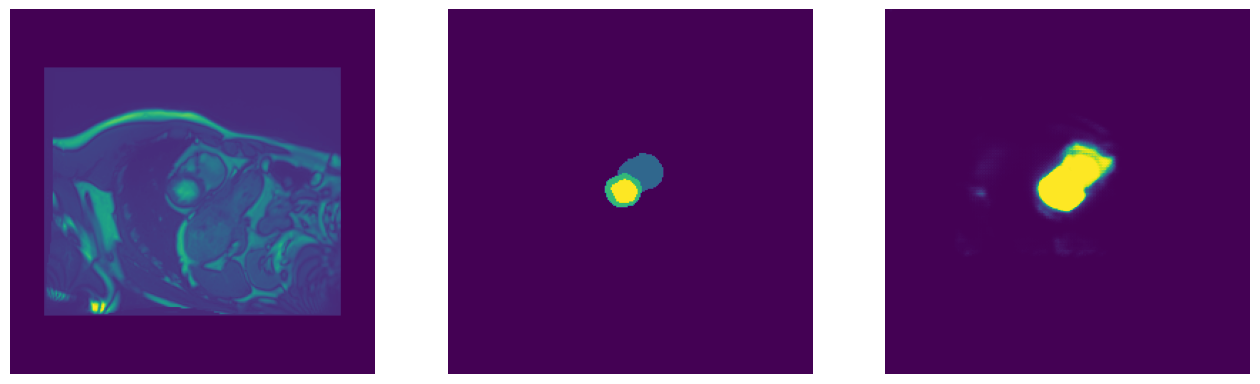

In [22]:
idx = random.randint(0, int(training_images.shape[0]) - 1)
show_results(idx, training_images, training_gt, train_prediction)

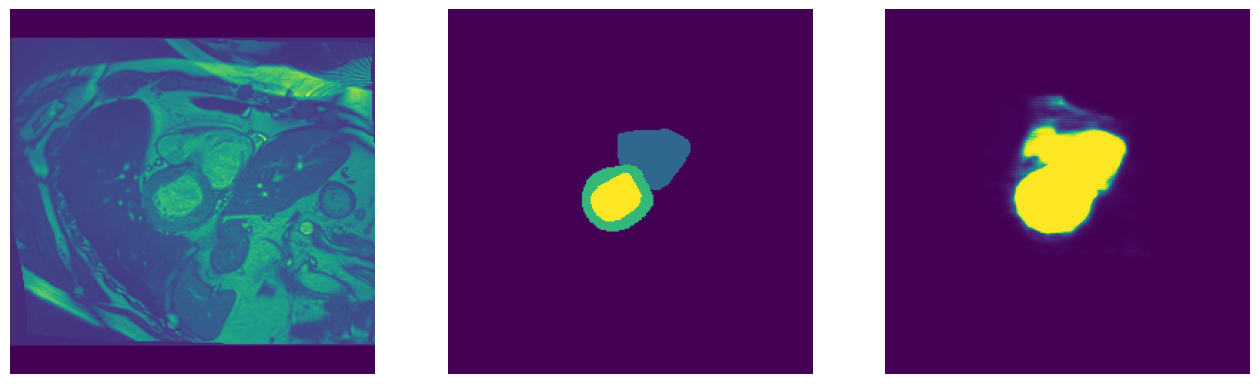

In [23]:
idx = random.randint(0, int(testing_images.shape[0]) - 1)
show_results(idx, testing_images, testing_gt, test_prediction)

In [24]:
def dice_coef(pred, true):
    intersection = (np.sum(pred[true==3]) * 2.0) + (np.sum(pred[true==2]) * 2.0) + (np.sum(pred[true==1]) * 2.0)
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [25]:
results_train = []
for pred, true in zip(train_prediction, training_gt):
  results_train.append(dice_coef(pred, true))

In [26]:
results_test = []
for pred, true in zip(test_prediction, testing_gt):
  results_test.append(dice_coef(pred, true))

Text(0.5, 1.0, 'Test, average:0.538')

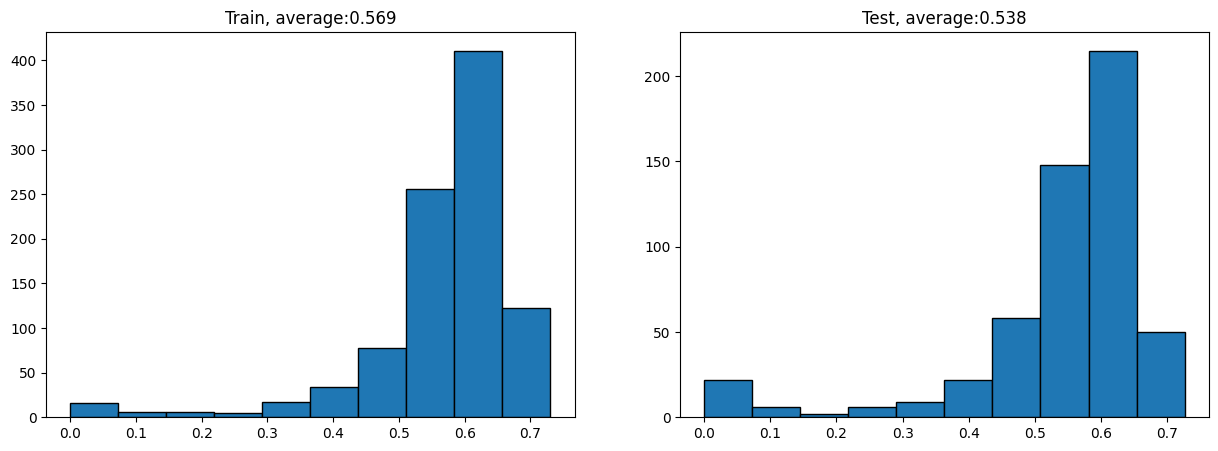

In [27]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.hist(results_train, bins=10, edgecolor='k')
plt.title('Train, average:{:.3f}'.format(sum(results_train)/len(results_train)))
plt.subplot(1, 2, 2)
plt.hist(results_test, bins=10, edgecolor='k')
plt.title('Test, average:{:.3f}'.format(sum(results_test)/len(results_test)))